In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from sklearn.model_selection import KFold
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import datetime
import os

In [95]:
import warnings

warnings.filterwarnings(action='ignore')

## Fix Random Seeds

In [96]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [97]:
set_seed(18)

## Parameter Setting

In [98]:
data_dir = 'fake_licenseplate'
num_classes = 2

batch_size = 32
num_epochs = 10
k_folds = 5
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model_weight_dir = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
os.makedirs(model_weight_dir, exist_ok=True)

train_transform = transforms.Compose([
    transforms.Resize((144, 48)),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((144, 48)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)

## Model Design

In [99]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = models.resnet18(pretrained=False)
        self.features.fc = nn.Linear(self.features.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        return x

## K-fold Cross Validation

In [100]:
kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'*** Fold {fold + 1} ***')

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=val_subsampler)

    model = SimpleCNN(num_classes=num_classes)
    model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    torch.save(model.state_dict(), f'./{model_weight_dir}/model-fold-{fold}.pth')
    results[fold] = val_acc

print(f'K-Fold Cross Validation results: {results}')
print(f'Average Accuracy: {np.mean(list(results.values())):.4f}')

*** Fold 1 ***
Fold 1, Epoch 1, Loss: 0.4005, Accuracy: 0.8545
Fold 1, Epoch 2, Loss: 1.6053, Accuracy: 0.2909
Fold 1, Epoch 3, Loss: 0.8435, Accuracy: 0.6727
Fold 1, Epoch 4, Loss: 2.2801, Accuracy: 0.5455
Fold 1, Epoch 5, Loss: 0.0903, Accuracy: 0.9818
Fold 1, Epoch 6, Loss: 0.1043, Accuracy: 0.9455
Fold 1, Epoch 7, Loss: 0.0705, Accuracy: 0.9818
Fold 1, Epoch 8, Loss: 0.0892, Accuracy: 0.9455
Fold 1, Epoch 9, Loss: 0.0954, Accuracy: 0.9455
Fold 1, Epoch 10, Loss: 0.1144, Accuracy: 0.9455
*** Fold 2 ***
Fold 2, Epoch 1, Loss: 0.3778, Accuracy: 0.8545
Fold 2, Epoch 2, Loss: 0.2823, Accuracy: 0.9273
Fold 2, Epoch 3, Loss: 0.2521, Accuracy: 0.9455
Fold 2, Epoch 4, Loss: 0.4342, Accuracy: 0.8909
Fold 2, Epoch 5, Loss: 0.2108, Accuracy: 0.9091
Fold 2, Epoch 6, Loss: 0.1880, Accuracy: 0.9636
Fold 2, Epoch 7, Loss: 0.2892, Accuracy: 0.9091
Fold 2, Epoch 8, Loss: 0.2838, Accuracy: 0.9273
Fold 2, Epoch 9, Loss: 0.2221, Accuracy: 0.9636
Fold 2, Epoch 10, Loss: 0.1898, Accuracy: 0.9636
*** Fold

## Prediction

In [106]:
class_names = {0: 'fake', 1: 'real'}

def predict_image(image, model, transform, class_names):
    model.eval()
    image = transform(image).unsqueeze(0)
    image = image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

def visualize_prediction(image_path, model, transform, class_names, fold='-'):
    image = Image.open(image_path)
    predicted_class = predict_image(image, model, transform, class_names)

    plt.imshow(image)
    plt.title(f'Fold: {fold} -> Predicted: {predicted_class} / Actual: {class_names[int(image_path.split("/")[-2])]}')
    plt.axis('off')
    plt.show()

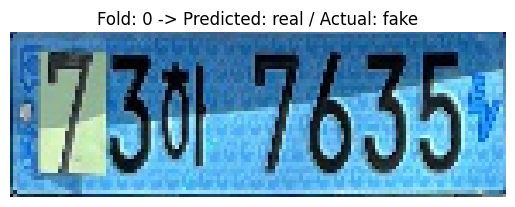

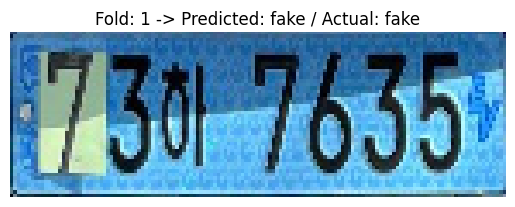

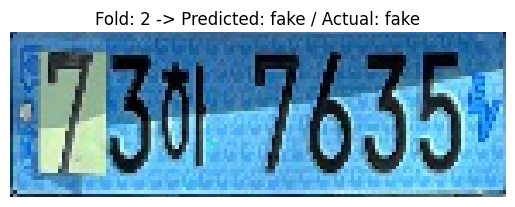

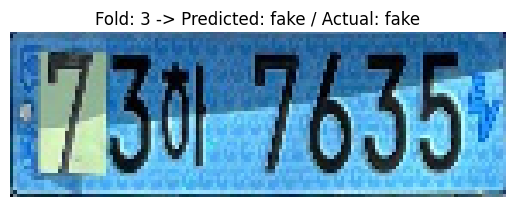

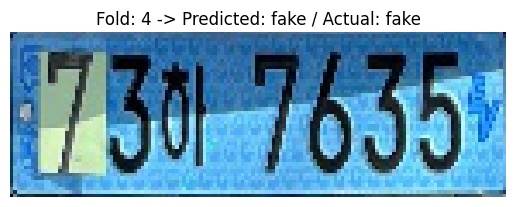

In [107]:
dir_path = '20240522164003'

for fold in range(k_folds):
    model = SimpleCNN(num_classes=num_classes)
    model.load_state_dict(torch.load(f'{dir_path}/model-fold-{fold}.pth'))
    model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    test_image_path = 'fake_licenseplate/0/46.jpg'
    visualize_prediction(test_image_path, model, test_transform, class_names, fold=fold)

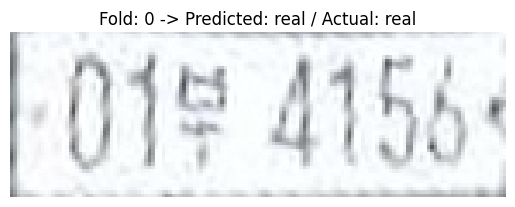

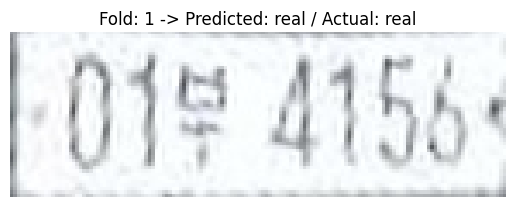

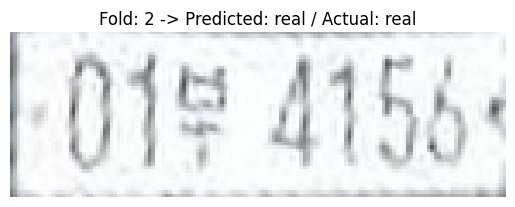

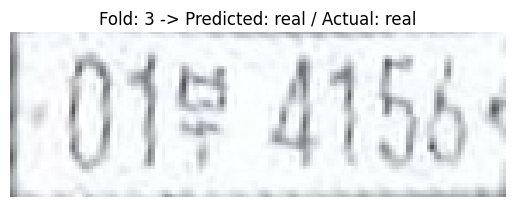

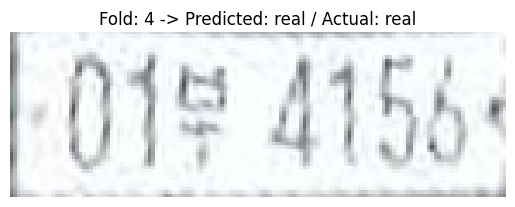

In [108]:
dir_path = '20240522164003'

for fold in range(k_folds):
    model = SimpleCNN(num_classes=num_classes)
    model.load_state_dict(torch.load(f'{dir_path}/model-fold-{fold}.pth'))
    model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    test_image_path = 'fake_licenseplate/1/281.jpg'
    visualize_prediction(test_image_path, model, test_transform, class_names, fold=fold)